# Anomaly Detection Challenge 2
## Miguel Sandim and Paula Fortuna

## 0 - Library Imports & Utils

In [1]:
# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Random libraries and seeds:
import random
random.seed(2)
np.random.seed(2)

pd.set_option('display.max_columns', None)

In [2]:
# From: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

######################################
# Function Save Data To CSV
######################################

def saveDataToCSV(Y_pred):
    id_list = range(0, len(Y_pred))
    submission = pd.DataFrame({
        "Id": id_list,
        "Expected": Y_pred
    })
    submission = submission[['Id', 'Expected']]
    submission.to_csv('submission.csv', index=False)
    return


# 1 - Data Reading

### 1.1 - Solve format problems

#### 1.1.1 -  yelp_data_train.dat and yelp_data_test.dat

In a text editor (e. g. sublime) use regex.

1) Replace " by ""

2) Surround text field with "
To match the first one use this (dont forget to remove the one that appears also in the begining of the sentence, and the one in the header):

^[^;]*;[^;]*;[^;]*;

Use this to find the last:

;[^;]*;[^;]*;[^;]*;[^;]*;[^;]*;[^;]*$ 

3) check if all the lines match the refered structure:

^[^;]*

4) Remove random newlines that appear in the rows and make new instance

#### 1.1.2 - yelp_data_reviewer.dat

1) ; caracter removed from fields

2) smiles removed from fields

#### 1.3 hotel file

1) removal of ; in the link

### 1.2 Load data (finally!)

In [3]:
# read from csv

train_df = pd.read_csv("data/yelp_data_train.dat", sep = ';', encoding = 'utf-8')
test_df = pd.read_csv("data/yelp_data_test.dat", sep = ';', encoding = 'utf-8')
reviewers_df = pd.read_csv("data/yelp_data_reviewer.dat", sep = ';', encoding = 'utf-8')
hotels_df = pd.read_csv("data/yelp_data_hotel.dat", sep = ';', encoding = 'utf-8')

In [4]:
train_df["fake"].value_counts()

N    2516
Y     392
Name: fake, dtype: int64

In [5]:
392/(392 + 2516)

0.13480055020632736

## About 13% of our dataset are anomalous cases. We also checked that each reviewer only reviewed each hotel once, at maximum.

# 2 - Data Pre-Processing

In [6]:
import sklearn.preprocessing as skpre

## Solve Missing Values

In [7]:
train_df.set_value(2550, 'reviewContent', ' ')

,date,reviewID,reviewerID,reviewContent,rating,usefulCount,coolCount,funnyCount,fake,hotelID
0,9/16/2010,Ol,nf3q2h-kSQoZK2jBY92FOg,"If you are considering staying here, watch thi...",1,8,2,6,N,tQfLGoolUMu2J0igcWcoZg
1,2/5/2010,i4HIAcNTjabdpG1K4F5Q2g,Sb3DJGdZ4Rq__CqxPbae-g,"This place is disgusting, absolutely horrible,...",3,11,4,9,N,tQfLGoolUMu2J0igcWcoZg
2,8/9/2010,veKKNAaSKWj8os,nR7zLyFOlzAYqmzgJ3DtXg,Disgusting!!! There is literally duct tape ho...,1,1,0,3,N,tQfLGoolUMu2J0igcWcoZg
3,8/11/2012,6c-ZiQkHXtp1n6VfiKDQ3g,747lP4p8dUD6RTkcsIaSGg,This hotel came up on Hotwire for $108 a night...,4,2,0,1,N,33Xc1Bk_gkSY5xb2doQ7Ng
4,7/9/2012,POWQ6FuUf3oe2ZkhmHvciA,Ij5t6VdwtasSkrpp9uAbKg,"Good location, really run down. I am surprised...",2,0,0,0,N,33Xc1Bk_gkSY5xb2doQ7Ng
5,6/19/2012,QBynYcLgIgtAd-YfnrrAtA,hSERzClUe57bCw3nCp4plA,Beautiful lobby. The rest is a dump. The eleva...,1,0,1,1,N,33Xc1Bk_gkSY5xb2doQ7Ng
6,9/14/2012,ELY3TK,OMm2VcGks3QL0p0n3_kPFw,Stayed here when I went to Chicago for a weddi...,3,2,0,0,N,33Xc1Bk_gkSY5xb2doQ7Ng
7,3/20/2012,uWKWYb5vDpeDGEAZUc192g,yevHGEUQQmnVlBXIrJ885A,I bleed SPG loyalty blood to the point where I...,1,1,1,0,N,33Xc1Bk_gkSY5xb2doQ7Ng
8,3/3/2012,hkt7Dnr7kRnLLd9pm-fxDw,Lql1_3zeGlny_Tgq4MI6Fg,"I stayed here a couple of times in 2011, as th...",3,0,0,0,N,33Xc1Bk_gkSY5xb2doQ7Ng
9,6/18/2012,ZlexD7XvkqH8yve4zCAR7g,RtyDimVdIBwjGdQr0dti1w,"This is an older property, so the decor is dat...",1,0,0,0,N,33Xc1Bk_gkSY5xb2doQ7Ng


## 2.1 - Feature Extraction

In [8]:
train_df.shape

(2908, 10)

In [9]:
reviewers_df

,reviewerID,name,location,yelpJoinDate,friendCount,reviewCount,firstCount,usefulCount,coolCount,funnyCount,complimentCount,tipCount,fanCount
0,yevHGEUQQmnVlBXIrJ885A,Kevin T.,"Oconomowoc, WI",May 2011,4,86,3,129,47,31,12,0,1
1,yoB_PYQHjnPjh78ATA0Jgw,Veronica B.,"Saint Paul, MN",January 2010,5,49,5,63,34,21,10,2,0
2,XrFCag4AMW5qta9QXokWPA,Paul The Commander M.,"Saint Louis, MO",August 2008,15,135,29,235,85,102,72,0,3
3,y5ptsWmvGEAftOQaiFhBcg,Stella BraveTart J.,"Lexington-Fayette, KY",September 2009,49,104,36,282,83,92,43,0,21
4,uUVZJm9yxNl5FBsXbt4WBg,Ginger 'where's my meds' v.,"San Francisco, CA",August 2008,22,34,2,81,32,52,5,0,1
5,ZCRY4GLLTli8tZRPi1P7Cw,Johan Johanna S.,"San Leandro, CA",August 2010,0,34,0,20,3,3,0,0,0
6,uOFIY6vBBp7O6un8CLggTw,Daniel Don Quijote K.,"Honolulu, HI",June 2011,72,51,0,57,19,16,8,0,1
7,tdE3__i2otI_nL3M3sy0MQ,Jen Mme Federer C.,"New York, NY",December 2008,136,238,37,200,103,40,55,10,2
8,Uu-qEGsSb72ngIQUF85rDQ,Anna P.,"New York, NY",March 2010,1,11,0,9,4,3,1,1,0
9,zyk-YPhtFZK6kkbpzEKrWw,Kara P.,"Covington, KY",December 2009,66,49,2,51,19,14,27,13,1


In [10]:
def maxNumberOfReviews(data):
    import datetime
    date_old = [datetime.datetime.strptime(x, "%B %Y") for x in data["yelpJoinDate"]]
    date_new = datetime.datetime.strptime("October 2012", "%B %Y") # Data da review mais antiga
    data["reviewsPerDay"] = data["reviewCount"] / [(date_new - x).days for x in date_old]
    
maxNumberOfReviews(reviewers_df)

In [11]:
def PPR():
    
    percentageReviews = []
    
    for r_id in reviewers_df["reviewerID"]:
        train_count = (train_df["reviewerID"] == r_id).sum()
        test_count = (test_df["reviewerID"] == r_id).sum()
        
        
        train_count_4 = train_df.loc[(train_df["reviewerID"] == r_id) & (train_df["rating"] > 4)].shape[0]
        test_count_4 = test_df.loc[(test_df["reviewerID"] == r_id) & (test_df["rating"] > 4)].shape[0]
        
        if ((train_count + test_count) == 0):
            percentageReviews.append(0.0)
        else:
            percentageReviews.append((train_count_4 + test_count_4) / (train_count + test_count))

    reviewers_df["percentageReviews"] = percentageReviews

        
    # para cada reviewer fazer get do ID,
        # Contar o nº de vezes que o ID aparece no train + test com >= 4
        # meter no revewer
        
PPR()

In [12]:
# Adapted from http://stackoverflow.com/questions/15173225/how-to-calculate-cosine-similarity-given-2-sentence-strings-python
def cosSim(text1, text2):
    import re, math
    from collections import Counter

    WORD = re.compile(r'\w+')

    def get_cosine(vec1, vec2):
        intersection = set(vec1.keys()) & set(vec2.keys())
        numerator = sum([vec1[x] * vec2[x] for x in intersection])

        sum1 = sum([vec1[x]**2 for x in vec1.keys()])
        sum2 = sum([vec2[x]**2 for x in vec2.keys()])
        denominator = math.sqrt(sum1) * math.sqrt(sum2)

        if not denominator:
            return(0.0)
        else:
            return(numerator / denominator)

    def text_to_vector(text):
        words = WORD.findall(text)
        return Counter(words)

    vector1 = text_to_vector(text1)
    vector2 = text_to_vector(text2)

    cosine = get_cosine(vector1, vector2)
    return(cosine)
    
def similarityUsers():
    import itertools as it
    
    mean_distance = []
    
    for r_id in reviewers_df["reviewerID"]:
        texts_train = train_df[train_df["reviewerID"] == r_id]["reviewContent"]
        texts_test = test_df[test_df["reviewerID"] == r_id]["reviewContent"]
        texts = np.append(texts_train, texts_test)
        
        #print("tamanho do texto %d" % len(texts))
        if (len(texts) == 0 or len(texts) == 1):
            mean_distance.append(0.0)
        else:
            # Get all combinations of reviews from an user:
            combs = list(it.combinations(texts,2))
            #print(len(texts))
            #print(len(combs))
            dist_list = [cosSim(comb[0], comb[1]) for comb in list(it.combinations(texts,2))]
            #print(dist_list)

            # Calculate the mean distance for the user's reviews
            mean_distance.append(np.mean(np.array(dist_list)))
        
    reviewers_df["reviewSimilarity"] = mean_distance 
    # percorrer os users
        # buscar todos os textos do user (indices)
            # ver a função das combinações e pedir a cosSim para todos, no fim fazer a media
similarityUsers()  

### Joining tables

In [13]:
train_df_joined = train_df.add_suffix("_review").join(reviewers_df.add_suffix("_user")).join(hotels_df.add_suffix("_hotel")).drop([
        "reviewerID_review",
        "hotelID_review"
    ], axis=1)

test_df_joined = test_df.add_suffix("_review").join(reviewers_df.add_suffix("_user")).join(hotels_df.add_suffix("_hotel")).drop([
        "reviewerID_review",
        "hotelID_review"
    ], axis=1)

In [14]:
train_df_joined.columns

Index(['date_review', 'reviewID_review', 'reviewContent_review',
       'rating_review', 'usefulCount_review', 'coolCount_review',
       'funnyCount_review', 'fake_review', 'reviewerID_user', 'name_user',
       'location_user', 'yelpJoinDate_user', 'friendCount_user',
       'reviewCount_user', 'firstCount_user', 'usefulCount_user',
       'coolCount_user', 'funnyCount_user', 'complimentCount_user',
       'tipCount_user', 'fanCount_user', 'reviewsPerDay_user',
       'percentageReviews_user', 'reviewSimilarity_user', 'hotelID_hotel',
       'name_hotel', 'location_hotel', 'reviewCount_hotel', 'rating_hotel',
       'categories_hotel', 'address_hotel', 'AcceptsCreditCards_hotel',
       'PriceRange_hotel', 'WiFi_hotel', 'webSite_hotel', 'phoneNumber_hotel',
       'filReviewCount_hotel'],
      dtype='object')

In [15]:
train_df_joined

,date_review,reviewID_review,reviewContent_review,rating_review,usefulCount_review,coolCount_review,funnyCount_review,fake_review,reviewerID_user,name_user,location_user,yelpJoinDate_user,friendCount_user,reviewCount_user,firstCount_user,usefulCount_user,coolCount_user,funnyCount_user,complimentCount_user,tipCount_user,fanCount_user,reviewsPerDay_user,percentageReviews_user,reviewSimilarity_user,hotelID_hotel,name_hotel,location_hotel,reviewCount_hotel,rating_hotel,categories_hotel,address_hotel,AcceptsCreditCards_hotel,PriceRange_hotel,WiFi_hotel,webSite_hotel,phoneNumber_hotel,filReviewCount_hotel
0,9/16/2010,Ol,"If you are considering staying here, watch thi...",1,8,2,6,N,yevHGEUQQmnVlBXIrJ885A,Kevin T.,"Oconomowoc, WI",May 2011,4,86,3,129,47,31,12,0,1,0.165703,0.000000,0.542826,pSLh_XyV_3QS1hNsBOGHiQ,Old Chicago Inn,"Old Chicago Inn - Lakeview - Chicago, IL",1,3.0,"Event Planning & Services, Hotels, Hotels & Tr...",3222 N Sheffield Ave (between Belmont Ave & Sc...,Yes,$$,Free,http://www.oldchicagoinn.com,(773) 245-0423,5
1,2/5/2010,i4HIAcNTjabdpG1K4F5Q2g,"This place is disgusting, absolutely horrible,...",3,11,4,9,N,yoB_PYQHjnPjh78ATA0Jgw,Veronica B.,"Saint Paul, MN",January 2010,5,49,5,63,34,21,10,2,0,0.048805,0.000000,0.000000,tQfLGoolUMu2J0igcWcoZg,Tokyo Hotel,"Tokyo Hotel - Near North Side - Chicago, IL",6,3.0,"Event Planning & Services, Hotels, Hotels & Tr...","19 E Ohio St Chicago, IL 60611 Neighborhood: N...",No,$,No,http://tokyohotels.webs.com/,(312) 787-4900,5
2,8/9/2010,veKKNAaSKWj8os,Disgusting!!! There is literally duct tape ho...,1,1,0,3,N,XrFCag4AMW5qta9QXokWPA,Paul The Commander M.,"Saint Louis, MO",August 2008,15,135,29,235,85,102,72,0,3,0.088699,0.000000,0.000000,33Xc1Bk_gkSY5xb2doQ7Ng,The Tremont Chicago Hotel at Magnificent Mile,The Tremont Chicago Hotel at Magnificent Mile ...,44,3.0,"Event Planning & Services, Hotels, Hotels & Tr...",100 East Chestnut (between Ernst Ct & Michigan...,Yes,$$,Free,http://www.tremontchicago.com,(312) 751-1900,5
3,8/11/2012,6c-ZiQkHXtp1n6VfiKDQ3g,This hotel came up on Hotwire for $108 a night...,4,2,0,1,N,y5ptsWmvGEAftOQaiFhBcg,Stella BraveTart J.,"Lexington-Fayette, KY",September 2009,49,104,36,282,83,92,43,0,21,0.092362,0.000000,0.000000,2nnXespKBBNtDQTtrumNFg,Inn At Lincoln Park,"Inn At Lincoln Park - Lincoln Park - Chicago, IL",20,2.0,"Event Planning & Services, Hotels, Hotels & Tr...",601 W Diversey Pkwy (between Broadway St & Cam...,Yes,$$$,Free,None,(773) 348-2810,5
4,7/9/2012,POWQ6FuUf3oe2ZkhmHvciA,"Good location, really run down. I am surprised...",2,0,0,0,N,uUVZJm9yxNl5FBsXbt4WBg,Ginger 'where's my meds' v.,"San Francisco, CA",August 2008,22,34,2,81,32,52,5,0,1,0.022339,0.000000,0.000000,SNuJYJewLhunxlhEezo15w,Carleton Hotel,"Carleton Hotel - Oak Park, IL",31,4.0,"Event Planning & Services, Hotels, Hotels & Tr...",1110 Pleasant St (between Maple Ave & Marion S...,Yes,$$,Free,http://www.carletonhotel.com/,(708) 848-5000,5
5,6/19/2012,QBynYcLgIgtAd-YfnrrAtA,Beautiful lobby. The rest is a dump. The eleva...,1,0,1,1,N,ZCRY4GLLTli8tZRPi1P7Cw,Johan Johanna S.,"San Leandro, CA",August 2010,0,34,0,20,3,3,0,0,0,0.042929,0.000000,0.000000,XZEBxlz9ZoP76CrYvEsL1A,Holiday Inn Express Hotel Chicago - Magnificen...,Holiday Inn Express Hotel Chicago - Magnificen...,19,3.5,"Event Planning & Services, Hotels, Hotels & Tr...",640 N Wabash Ave (between Ontario St & Erie St...,Yes,$$,Free,http://www.holidayinnexpress.com,(312) 787-4030,5
6,9/14/2012,ELY3TK,Stayed here when I went to Chicago for a weddi...,3,2,0,0,N,uOFIY6vBBp7O6un8CLggTw,Daniel Don Quijote K.,"Honolulu, HI",June 2011,72,51,0,57,19,16,8,0,1,0.104508,0.000000,0.000000,FfG-PPZCz1sB4SKZoqsZkQ,The Whitehall Hotel,The Whitehall Hotel - Near North Side - Chicag...,58,3.5,"Event Planning & Services, Hotels, Hotels & Tr...",105 E Delaware Pl (between Ernst Ct & Huguelet...,Yes,$$,Paid,http://www.thewhitehallhotel.com/?…,(312) 944-6300,6
7,3/20/2012,uWKWYb5vDpeDGEAZUc192g,I bleed SPG loyalty blood to the point where I...,1,1,1,

In [16]:
test_df_joined

,id_review,date_review,reviewID_review,reviewContent_review,rating_review,usefulCount_review,coolCount_review,funnyCount_review,reviewerID_user,name_user,location_user,yelpJoinDate_user,friendCount_user,reviewCount_user,firstCount_user,usefulCount_user,coolCount_user,funnyCount_user,complimentCount_user,tipCount_user,fanCount_user,reviewsPerDay_user,percentageReviews_user,reviewSimilarity_user,hotelID_hotel,name_hotel,location_hotel,reviewCount_hotel,rating_hotel,categories_hotel,address_hotel,AcceptsCreditCards_hotel,PriceRange_hotel,WiFi_hotel,webSite_hotel,phoneNumber_hotel,filReviewCount_hotel
0,0,6/8/2011,MyNjnxzZVTPq,Let me begin by saying that there are two kind...,5,18,11,28,yevHGEUQQmnVlBXIrJ885A,Kevin T.,"Oconomowoc, WI",May 2011,4,86,3,129,47,31,12,0,1,0.165703,0.000000,0.542826,pSLh_XyV_3QS1hNsBOGHiQ,Old Chicago Inn,"Old Chicago Inn - Lakeview - Chicago, IL",1,3.0,"Event Planning & Services, Hotels, Hotels & Tr...",3222 N Sheffield Ave (between Belmont Ave & Sc...,Yes,$$,Free,http://www.oldchicagoinn.com,(773) 245-0423,5
1,1,8/30/2011,BdD7fsPqHQL73hwENEDT-Q,The only place inside the Loop that you can st...,3,0,3,4,yoB_PYQHjnPjh78ATA0Jgw,Veronica B.,"Saint Paul, MN",January 2010,5,49,5,63,34,21,10,2,0,0.048805,0.000000,0.000000,tQfLGoolUMu2J0igcWcoZg,Tokyo Hotel,"Tokyo Hotel - Near North Side - Chicago, IL",6,3.0,"Event Planning & Services, Hotels, Hotels & Tr...","19 E Ohio St Chicago, IL 60611 Neighborhood: N...",No,$,No,http://tokyohotels.webs.com/,(312) 787-4900,5
2,2,6/26/2009,BfhqiyfC,I have walked by the Tokyo Hotel countless tim...,5,12,14,23,XrFCag4AMW5qta9QXokWPA,Paul The Commander M.,"Saint Louis, MO",August 2008,15,135,29,235,85,102,72,0,3,0.088699,0.000000,0.000000,33Xc1Bk_gkSY5xb2doQ7Ng,The Tremont Chicago Hotel at Magnificent Mile,The Tremont Chicago Hotel at Magnificent Mile ...,44,3.0,"Event Planning & Services, Hotels, Hotels & Tr...",100 East Chestnut (between Ernst Ct & Michigan...,Yes,$$,Free,http://www.tremontchicago.com,(312) 751-1900,5
3,3,12/2/2011,cQdmhpNvyBv8nHEoxQdq9w,I'm a SPG Platinum member and can't believe th...,2,1,1,0,y5ptsWmvGEAftOQaiFhBcg,Stella BraveTart J.,"Lexington-Fayette, KY",September 2009,49,104,36,282,83,92,43,0,21,0.092362,0.000000,0.000000,2nnXespKBBNtDQTtrumNFg,Inn At Lincoln Park,"Inn At Lincoln Park - Lincoln Park - Chicago, IL",20,2.0,"Event Planning & Services, Hotels, Hotels & Tr...",601 W Diversey Pkwy (between Broadway St & Cam...,Yes,$$$,Free,None,(773) 348-2810,5
4,4,6/3/2012,kgVxanwQ0fbPKOq-o6b9GA,"Pros: fantastic location at a good price, stat...",3,0,0,0,uUVZJm9yxNl5FBsXbt4WBg,Ginger 'where's my meds' v.,"San Francisco, CA",August 2008,22,34,2,81,32,52,5,0,1,0.022339,0.000000,0.000000,SNuJYJewLhunxlhEezo15w,Carleton Hotel,"Carleton Hotel - Oak Park, IL",31,4.0,"Event Planning & Services, Hotels, Hotels & Tr...",1110 Pleasant St (between Maple Ave & Marion S...,Yes,$$,Free,http://www.carletonhotel.com/,(708) 848-5000,5
5,5,8/12/2012,9m2Ei7twJOn5esfiE9dT9w,let us begin with the seven min wait for the o...,1,0,0,0,ZCRY4GLLTli8tZRPi1P7Cw,Johan Johanna S.,"San Leandro, CA",August 2010,0,34,0,20,3,3,0,0,0,0.042929,0.000000,0.000000,XZEBxlz9ZoP76CrYvEsL1A,Holiday Inn Express Hotel Chicago - Magnificen...,Holiday Inn Express Hotel Chicago - Magnificen...,19,3.5,"Event Planning & Services, Hotels, Hotels & Tr...",640 N Wabash Ave (between Ontario St & Erie St...,Yes,$$,Free,http://www.holidayinnexpress.com,(312) 787-4030,5
6,6,2/17/2011,W6iFBr,Traveling on a budget is what brought me here....,2,0,0,0,uOFIY6vBBp7O6un8CLggTw,Daniel Don Quijote K.,"Honolulu, HI",June 2011,72,51,0,57,19,16,8,0,1,0.104508,0.000000,0.000000,FfG-PPZCz1sB4SKZoqsZkQ,The Whitehall Hotel,The Whitehall Hotel - Near North Side - Chicag...,58,3.5,"Event Planning & Services, Hotels, Hotels & Tr...",105 E Delaware Pl (between Ernst Ct & Huguelet...,Yes,$$,Paid,http://www.thewhitehallhotel.com/?…,(312) 944-6300,6
7,7,7/26/2007,-tyvRLdz-vGKHAYm7xZHWw,"As Martha would say, ""What a dump!"" Although n

In [17]:
train_df_joined.to_csv("train_joined.csv", encoding='utf-8')

### 2.1.1 - Text Mining

In [18]:
# bag of words based in the words referenced in the paper
def bagOfWords(data): 
    personal_pronouns = ['i', 'we', 'me', 'us', 'my', 'mine', 'our', 'ours']
    associated_actions = ['went', 'feel']
    targets = ['area', 'options', 'price', 'stay']
    emotion_words = ['nice', 'deal', 'comfort', 'helpful']

    import collections, re

    # put in lower case
    data['reviewContent_review'] = data['reviewContent_review'].str.lower()
    
    # Replace characters
    data['reviewContent_review'] = data['reviewContent_review'].str.replace('\xa0',' ')
    
    texts = list(data['reviewContent_review'])
    bagsofwords = [collections.Counter(re.findall(r'\w+', txt)) 
                   for txt in texts]

    def count_words(data, word_list, attribute_name):
        data[attribute_name] = np.nan
        for i in range(0, data.shape[0]):
            num = 0
            for word in word_list:
                num += bagsofwords[i][word]
            data.set_value(i, attribute_name, num)

    count_words(data, personal_pronouns, 'count_pronouns')
    count_words(data, associated_actions, 'count_associated_actions')
    count_words(data, targets, 'count_targets')
    count_words(data, emotion_words, 'count_emotion_words')
    
bagOfWords(train_df_joined)
bagOfWords(test_df_joined)

In [19]:
def lengthReview(data):
    data['text_length'] = data['reviewContent_review'].str.len() 
    data['word_count'] = data['reviewContent_review'].str.count(' ')
    
lengthReview(train_df_joined)
lengthReview(test_df_joined)

### 2.1.2. - Other features

In [20]:
def deviationFromHotelRating(data):
    data["deviatonReviewHotel"] = data["rating_review"] - data["rating_hotel"]

deviationFromHotelRating(train_df_joined)
deviationFromHotelRating(test_df_joined)

In [21]:
train_df_joined

,date_review,reviewID_review,reviewContent_review,rating_review,usefulCount_review,coolCount_review,funnyCount_review,fake_review,reviewerID_user,name_user,location_user,yelpJoinDate_user,friendCount_user,reviewCount_user,firstCount_user,usefulCount_user,coolCount_user,funnyCount_user,complimentCount_user,tipCount_user,fanCount_user,reviewsPerDay_user,percentageReviews_user,reviewSimilarity_user,hotelID_hotel,name_hotel,location_hotel,reviewCount_hotel,rating_hotel,categories_hotel,address_hotel,AcceptsCreditCards_hotel,PriceRange_hotel,WiFi_hotel,webSite_hotel,phoneNumber_hotel,filReviewCount_hotel,count_pronouns,count_associated_actions,count_targets,count_emotion_words,text_length,word_count,deviatonReviewHotel
0,9/16/2010,Ol,"if you are considering staying here, watch thi...",1,8,2,6,N,yevHGEUQQmnVlBXIrJ885A,Kevin T.,"Oconomowoc, WI",May 2011,4,86,3,129,47,31,12,0,1,0.165703,0.000000,0.542826,pSLh_XyV_3QS1hNsBOGHiQ,Old Chicago Inn,"Old Chicago Inn - Lakeview - Chicago, IL",1,3.0,"Event Planning & Services, Hotels, Hotels & Tr...",3222 N Sheffield Ave (between Belmont Ave & Sc...,Yes,$$,Free,http://www.oldchicagoinn.com,(773) 245-0423,5,0.0,0.0,0.0,0.0,80,9,-2.0
1,2/5/2010,i4HIAcNTjabdpG1K4F5Q2g,"this place is disgusting, absolutely horrible,...",3,11,4,9,N,yoB_PYQHjnPjh78ATA0Jgw,Veronica B.,"Saint Paul, MN",January 2010,5,49,5,63,34,21,10,2,0,0.048805,0.000000,0.000000,tQfLGoolUMu2J0igcWcoZg,Tokyo Hotel,"Tokyo Hotel - Near North Side - Chicago, IL",6,3.0,"Event Planning & Services, Hotels, Hotels & Tr...","19 E Ohio St Chicago, IL 60611 Neighborhood: N...",No,$,No,http://tokyohotels.webs.com/,(312) 787-4900,5,5.0,0.0,2.0,0.0,251,48,0.0
2,8/9/2010,veKKNAaSKWj8os,disgusting!!! there is literally duct tape ho...,1,1,0,3,N,XrFCag4AMW5qta9QXokWPA,Paul The Commander M.,"Saint Louis, MO",August 2008,15,135,29,235,85,102,72,0,3,0.088699,0.000000,0.000000,33Xc1Bk_gkSY5xb2doQ7Ng,The Tremont Chicago Hotel at Magnificent Mile,The Tremont Chicago Hotel at Magnificent Mile ...,44,3.0,"Event Planning & Services, Hotels, Hotels & Tr...",100 East Chestnut (between Ernst Ct & Michigan...,Yes,$$,Free,http://www.tremontchicago.com,(312) 751-1900,5,1.0,0.0,2.0,0.0,452,90,-2.0
3,8/11/2012,6c-ZiQkHXtp1n6VfiKDQ3g,this hotel came up on hotwire for $108 a night...,4,2,0,1,N,y5ptsWmvGEAftOQaiFhBcg,Stella BraveTart J.,"Lexington-Fayette, KY",September 2009,49,104,36,282,83,92,43,0,21,0.092362,0.000000,0.000000,2nnXespKBBNtDQTtrumNFg,Inn At Lincoln Park,"Inn At Lincoln Park - Lincoln Park - Chicago, IL",20,2.0,"Event Planning & Services, Hotels, Hotels & Tr...",601 W Diversey Pkwy (between Broadway St & Cam...,Yes,$$$,Free,None,(773) 348-2810,5,9.0,0.0,4.0,0.0,1486,292,2.0
4,7/9/2012,POWQ6FuUf3oe2ZkhmHvciA,"good location, really run down. i am surprised...",2,0,0,0,N,uUVZJm9yxNl5FBsXbt4WBg,Ginger 'where's my meds' v.,"San Francisco, CA",August 2008,22,34,2,81,32,52,5,0,1,0.022339,0.000000,0.000000,SNuJYJewLhunxlhEezo15w,Carleton Hotel,"Carleton Hotel - Oak Park, IL",31,4.0,"Event Planning & Services, Hotels, Hotels & Tr...",1110 Pleasant St (between Maple Ave & Marion S...,Yes,$$,Free,http://www.carletonhotel.com/,(708) 848-5000,5,1.0,0.0,0.0,0.0,91,14,-2.0
5,6/19/2012,QBynYcLgIgtAd-YfnrrAtA,beautiful lobby. the rest is a dump. the eleva...,1,0,1,1,N,ZCRY4GLLTli8tZRPi1P7Cw,Johan Johanna S.,"San Leandro, CA",August 2010,0,34,0,20,3,3,0,0,0,0.042929,0.000000,0.000000,XZEBxlz9ZoP76CrYvEsL1A,Holiday Inn Express Hotel Chicago - Magnificen...,Holiday Inn Express Hotel Chicago - Magnificen...,19,3.5,"Event Planning & Services, Hotels, Hotels & Tr...",640 N Wabash Ave (between Ontario St & Erie St...,Yes,$$,Free,http://www.holidayinnexpress.com,(312) 787-4030,5,1.0,0.0,0.0,1.0,602,108,-2.5
6,9/14/2012,ELY3TK,stayed here when i went to chicago for a weddi...,3,2,0,0,N,uOFIY6vBBp7O6un8CLggTw,Daniel Don Quijote K.,"Honolulu, HI",June 2011,72,51,0,57,19,16,8,0,1,0.104508,0.000000,0.000000,FfG-PPZCz1sB4SKZoqsZkQ,The Whitehall Hotel,The Whitehall Hotel - Near North

In [22]:
test_df_joined

,id_review,date_review,reviewID_review,reviewContent_review,rating_review,usefulCount_review,coolCount_review,funnyCount_review,reviewerID_user,name_user,location_user,yelpJoinDate_user,friendCount_user,reviewCount_user,firstCount_user,usefulCount_user,coolCount_user,funnyCount_user,complimentCount_user,tipCount_user,fanCount_user,reviewsPerDay_user,percentageReviews_user,reviewSimilarity_user,hotelID_hotel,name_hotel,location_hotel,reviewCount_hotel,rating_hotel,categories_hotel,address_hotel,AcceptsCreditCards_hotel,PriceRange_hotel,WiFi_hotel,webSite_hotel,phoneNumber_hotel,filReviewCount_hotel,count_pronouns,count_associated_actions,count_targets,count_emotion_words,text_length,word_count,deviatonReviewHotel
0,0,6/8/2011,MyNjnxzZVTPq,let me begin by saying that there are two kind...,5,18,11,28,yevHGEUQQmnVlBXIrJ885A,Kevin T.,"Oconomowoc, WI",May 2011,4,86,3,129,47,31,12,0,1,0.165703,0.000000,0.542826,pSLh_XyV_3QS1hNsBOGHiQ,Old Chicago Inn,"Old Chicago Inn - Lakeview - Chicago, IL",1,3.0,"Event Planning & Services, Hotels, Hotels & Tr...",3222 N Sheffield Ave (between Belmont Ave & Sc...,Yes,$$,Free,http://www.oldchicagoinn.com,(773) 245-0423,5,7.0,0.0,3.0,0.0,2249,418,2.0
1,1,8/30/2011,BdD7fsPqHQL73hwENEDT-Q,the only place inside the loop that you can st...,3,0,3,4,yoB_PYQHjnPjh78ATA0Jgw,Veronica B.,"Saint Paul, MN",January 2010,5,49,5,63,34,21,10,2,0,0.048805,0.000000,0.000000,tQfLGoolUMu2J0igcWcoZg,Tokyo Hotel,"Tokyo Hotel - Near North Side - Chicago, IL",6,3.0,"Event Planning & Services, Hotels, Hotels & Tr...","19 E Ohio St Chicago, IL 60611 Neighborhood: N...",No,$,No,http://tokyohotels.webs.com/,(312) 787-4900,5,0.0,0.0,1.0,0.0,261,52,0.0
2,2,6/26/2009,BfhqiyfC,i have walked by the tokyo hotel countless tim...,5,12,14,23,XrFCag4AMW5qta9QXokWPA,Paul The Commander M.,"Saint Louis, MO",August 2008,15,135,29,235,85,102,72,0,3,0.088699,0.000000,0.000000,33Xc1Bk_gkSY5xb2doQ7Ng,The Tremont Chicago Hotel at Magnificent Mile,The Tremont Chicago Hotel at Magnificent Mile ...,44,3.0,"Event Planning & Services, Hotels, Hotels & Tr...",100 East Chestnut (between Ernst Ct & Michigan...,Yes,$$,Free,http://www.tremontchicago.com,(312) 751-1900,5,29.0,0.0,4.0,0.0,1239,227,2.0
3,3,12/2/2011,cQdmhpNvyBv8nHEoxQdq9w,i'm a spg platinum member and can't believe th...,2,1,1,0,y5ptsWmvGEAftOQaiFhBcg,Stella BraveTart J.,"Lexington-Fayette, KY",September 2009,49,104,36,282,83,92,43,0,21,0.092362,0.000000,0.000000,2nnXespKBBNtDQTtrumNFg,Inn At Lincoln Park,"Inn At Lincoln Park - Lincoln Park - Chicago, IL",20,2.0,"Event Planning & Services, Hotels, Hotels & Tr...",601 W Diversey Pkwy (between Broadway St & Cam...,Yes,$$$,Free,None,(773) 348-2810,5,5.0,0.0,0.0,0.0,653,118,0.0
4,4,6/3/2012,kgVxanwQ0fbPKOq-o6b9GA,"pros: fantastic location at a good price, stat...",3,0,0,0,uUVZJm9yxNl5FBsXbt4WBg,Ginger 'where's my meds' v.,"San Francisco, CA",August 2008,22,34,2,81,32,52,5,0,1,0.022339,0.000000,0.000000,SNuJYJewLhunxlhEezo15w,Carleton Hotel,"Carleton Hotel - Oak Park, IL",31,4.0,"Event Planning & Services, Hotels, Hotels & Tr...",1110 Pleasant St (between Maple Ave & Marion S...,Yes,$$,Free,http://www.carletonhotel.com/,(708) 848-5000,5,0.0,0.0,1.0,0.0,296,42,-1.0
5,5,8/12/2012,9m2Ei7twJOn5esfiE9dT9w,let us begin with the seven min wait for the o...,1,0,0,0,ZCRY4GLLTli8tZRPi1P7Cw,Johan Johanna S.,"San Leandro, CA",August 2010,0,34,0,20,3,3,0,0,0,0.042929,0.000000,0.000000,XZEBxlz9ZoP76CrYvEsL1A,Holiday Inn Express Hotel Chicago - Magnificen...,Holiday Inn Express Hotel Chicago - Magnificen...,19,3.5,"Event Planning & Services, Hotels, Hotels & Tr...",640 N Wabash Ave (between Ontario St & Erie St...,Yes,$$,Free,http://www.holidayinnexpress.com,(312) 787-4030,5,3.0,0.0,0.0,1.0,567,122,-2.5
6,6,2/17/2011,W6iFBr,traveling on a budget is what brought me here....,2,0,0,0,uOFIY6vBBp7O6un8CLggTw,Daniel Don Quijote K.,"Honolulu, HI",June 2011,72,51,0,57,19,16,8,0,1,0.104508,0.000000,0.000000,FfG-PPZCz1sB4SKZoqsZkQ,The Whitehall Hotel,The Whitehall Hotel - 

## 2.2 - Missing Values

## 2.3 Normalization



## 2.4 Feature Selection

## Sampling

In [23]:
def undersampling():
    maioritary_indices = np.where(Y_train == 0)[0]
    minority_indices = np.where(Y_train == 1)[0]
    
    sample_size = sum(Y_train == 1)
    random_indices = np.random.choice(maioritary_indices, sample_size, replace=False)
    
    new_X_train = X_train.iloc[np.append(random_indices, minority_indices)]
    return(new_X_train)
    
X_train = undersampling()  

NameError: name 'Y_train' is not defined

## 2.5 Define global variables for the model

In [24]:
def encodeVariables():
    
    target_variable = "fake_review" # target variable
    
    dropVariableList = [
        "date_review",
        "reviewID_review",
        "reviewContent_review",
        "reviewerID_user",
        "location_user",
        "name_user",
        "yelpJoinDate_user",
        "hotelID_hotel",
        "name_hotel",
        "location_hotel",
        "categories_hotel",
        "address_hotel",
        "webSite_hotel",
        "phoneNumber_hotel",
        ## new variable drop
        "reviewCount_user",
        "AcceptsCreditCards_hotel",
        "PriceRange_hotel",
        "WiFi_hotel"
        ]

    # Drop variables in the X
    X_train = train_df_joined.drop(dropVariableList, axis=1)
    X_train = X_train.drop(target_variable, axis=1)
    X_test = test_df_joined.drop(dropVariableList, axis=1)
    X_test = X_test.drop("id_review", axis=1)
    
    # Drop variables in the Y
    Y_train = train_df_joined["fake_review"]

    # Transform categorical variables for X_train:
    categoricalVariableList = [
        #"AcceptsCreditCards_hotel",
        #"PriceRange_hotel",
        #"WiFi_hotel"
    ]
    
    for var_name in categoricalVariableList:
        encoder = skpre.LabelEncoder().fit(X_train[var_name])
        X_train[var_name] = encoder.transform(X_train[var_name])
        X_test[var_name] = encoder.transform(X_test[var_name])

    # Transform categorical variables for Y_train
    Y_train = skpre.LabelEncoder().fit_transform(Y_train)

    print(X_train)
    #print(X_test)
    print(Y_train)
    
    return X_train, Y_train, X_test
    
X_train, Y_train, X_test = encodeVariables()

      rating_review  usefulCount_review  coolCount_review  funnyCount_review  \
0                 1                   8                 2                  6   
1                 3                  11                 4                  9   
2                 1                   1                 0                  3   
3                 4                   2                 0                  1   
4                 2                   0                 0                  0   
5                 1                   0                 1                  1   
6                 3                   2                 0                  0   
7                 1                   1                 1                  0   
8                 3                   0                 0                  0   
9                 1                   0                 0                  0   
10                2                   0                 0                  0   
11                2                   2 

In [25]:
X_train

,rating_review,usefulCount_review,coolCount_review,funnyCount_review,friendCount_user,firstCount_user,usefulCount_user,coolCount_user,funnyCount_user,complimentCount_user,tipCount_user,fanCount_user,reviewsPerDay_user,percentageReviews_user,reviewSimilarity_user,reviewCount_hotel,rating_hotel,filReviewCount_hotel,count_pronouns,count_associated_actions,count_targets,count_emotion_words,text_length,word_count,deviatonReviewHotel
0,1,8,2,6,4,3,129,47,31,12,0,1,0.165703,0.000000,0.542826,1,3.0,5,0.0,0.0,0.0,0.0,80,9,-2.0
1,3,11,4,9,5,5,63,34,21,10,2,0,0.048805,0.000000,0.000000,6,3.0,5,5.0,0.0,2.0,0.0,251,48,0.0
2,1,1,0,3,15,29,235,85,102,72,0,3,0.088699,0.000000,0.000000,44,3.0,5,1.0,0.0,2.0,0.0,452,90,-2.0
3,4,2,0,1,49,36,282,83,92,43,0,21,0.092362,0.000000,0.000000,20,2.0,5,9.0,0.0,4.0,0.0,1486,292,2.0
4,2,0,0,0,22,2,81,32,52,5,0,1,0.022339,0.000000,0.000000,31,4.0,5,1.0,0.0,0.0,0.0,91,14,-2.0
5,1,0,1,1,0,0,20,3,3,0,0,0,0.042929,0.000000,0.000000,19,3.5,5,1.0,0.0,0.0,1.0,602,108,-2.5
6,3,2,0,0,72,0,57,19,16,8,0,1,0.104508,0.000000,0.000000,58,3.5,6,8.0,1.0,1.0,0.0,731,134,-0.5
7,1,1,1,0,136,37,200,103,40,55,10,2,0.170000,0.000000,0.000000,34,4.0,5,11.0,0.0,2.0,0.0,965,185,-3.0
8,3,0,0,0,1,0,9,4,3,1,1,0,0.011640,0.000000,0.110265,46,3.5,5,2.0,0.0,2.0,0.0,498,92,-0.5
9,1,0,0,0,66,2,51,19,14,27,13,1,0.047343,0.000000,0.528111,11,3.0,5,8.0,0.0,0.0,0.0,644,111,-2.0


In [ ]:
X_train.columns

## 2.6 - Sampling

### Save for CSV

## 3.1 - Model selection based on which models do best in CV using default settings:

LR: 0.802815 (0.029938)
LDA: 0.733741 (0.035496)


C:\Users\migsa\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\migsa\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\migsa\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\migsa\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\migsa\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\migsa\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\migsa\Anacond

KNN: 0.564087 (0.032629)
CART: 0.606057 (0.043817)
NB: 0.812072 (0.022804)
NN: 0.584202 (0.094168)
RF: 0.793991 (0.040358)
AB: 0.848420 (0.034135)
XGB: 0.853914 (0.037078)


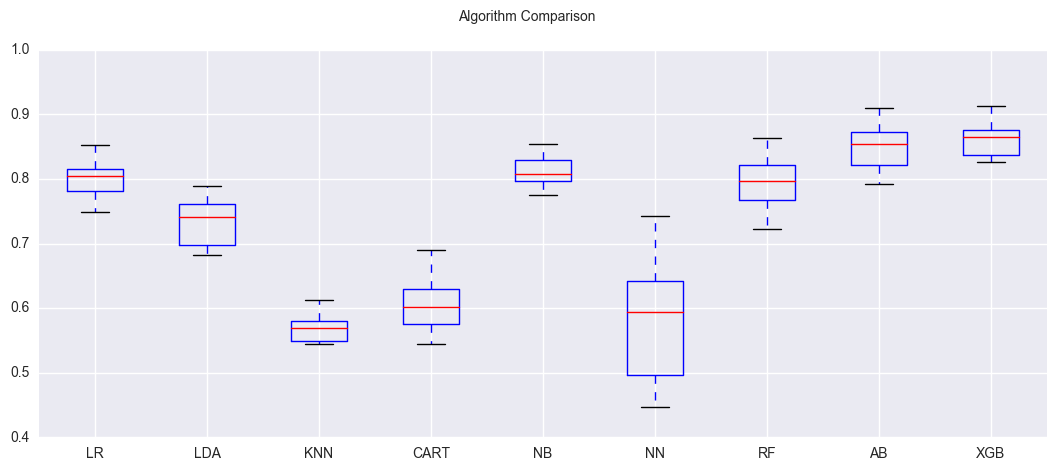

In [26]:
#inspired in http://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/

import sklearn.model_selection as mds
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb

def modelSelection():

    # prepare data

    #Y_train = train_df[:,-1]
    #X_train = train_df[:,:-1]

    #Y_train = train_df[len(train_df.columns)-1]
    #X_train = train_df.drop(len(train_df.columns)-1,axis=1)

    # prepare configuration for cross validation test harness
    num_folds = 10
    num_instances = len(X_train)

    # prepare models
    models = []
    models.append(('LR', LogisticRegression()))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('NB', GaussianNB()))
    #models.append(('SVM-Linear', SVC(kernel="linear")))
    #models.append(('SVM-Poly', SVC(kernel="poly")))
    #models.append(('SVM-RBF', SVC(kernel="rbf")))
    models.append(('NN', MLPClassifier(alpha=1))) 
    models.append(('RF', RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)))
    models.append(('AB', AdaBoostClassifier()))
    models.append(('XGB', xgb.XGBClassifier()))

    # evaluate each model in turn
    results = []
    scoring = 'roc_auc' # try with 'roc_auc', f1'

    kfold = mds.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=2)

    for model_name, model in models:
        cv_results = mds.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
        results.append({"name": model_name, "cv_results": cv_results, "mean": cv_results.mean(), "std": cv_results.std()})
        print("%s: %f (%f)" % (model_name, cv_results.mean(), cv_results.std()))

    # boxplot algorithm comparison
    fig = plt.figure(figsize=(13, 5), dpi=500)
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot([x["cv_results"] for x in results])
    ax.set_xticklabels([x["name"] for x in results])
    plt.show()

    # order the models by the mean auc
    #results_by_strategy.sort(key=lambda x: x["mean"], reverse=True)
    #print([(x["name"], x["mean"]) for x in results])

modelSelection()

### Results sorted by AUC

In [ ]:
results_sorted = [(na_method, algorithm["name"], algorithm["mean"]) for na_method in results for algorithm in results[na_method]]
results_sorted.sort(key=lambda x: x[2], reverse=True)
results_sorted

In [ ]:
def plotSupervisedAlgorithmsDefault(inf, sup):
    plt.figure(figsize=(13, 7), dpi=500)
    
    # x axis
    labels = [na_method for na_method in results]
    labels.sort()
    plt.xticks(np.arange(len(labels)), labels, rotation='vertical')
    plt.ylim(inf, sup)
    
    # legend:
    algorithm_names = [x["name"] for x in results["01-zero"]] 
    
    [plt.plot([[x["mean"] for x in results[na_method] if x["name"] == alg_name] for na_method in sorted(results)],
              label = alg_name) for alg_name in algorithm_names]
    
    plt.ylabel('AUC')
    plt.xlabel('NA-filling method')
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    
plotSupervisedAlgorithmsDefault(0.69, 1)
plotSupervisedAlgorithmsDefault(0.9, 1)
plotSupervisedAlgorithmsDefault(0.99, 1)

### Based on this plot, we decided to tune XGB and LDA and use 07-spec-mean and 09-spec-min

In [ ]:
def plotConfusionMatrixBestXGB():
    kfold = mds.StratifiedKFold(n_splits=2, shuffle=True, random_state=2)
    train, test = kfold.split(datasets["07-spec-mean"]["train"], Y_train)

    lol = xgb.XGBClassifier().fit(datasets["07-spec-mean"]["train"].iloc[train[0]], Y_train[train[0]])

    train1_pred = lol.predict(datasets["07-spec-mean"]["train"].iloc[train[1]])

    plot_confusion_matrix(confusion_matrix(Y_train[train[1]], train1_pred, labels = [0, 1]), classes = [0, 1])
    
plotConfusionMatrixBestXGB()

In [ ]:
def plotConfusionMatrixBestLDA():
    kfold = mds.StratifiedKFold(n_splits=2, shuffle=True, random_state=2)
    train, test = kfold.split(datasets["09-spec-min"]["train"], Y_train)

    lol = xgb.XGBClassifier().fit(datasets["09-spec-min"]["train"].iloc[train[0]], Y_train[train[0]])

    train1_pred = lol.predict(datasets["09-spec-min"]["train"].iloc[train[1]])

    plot_confusion_matrix(confusion_matrix(Y_train[train[1]], train1_pred, labels = [0, 1]), classes = [0, 1])
    
plotConfusionMatrixBestLDA()

### 3.1.1 - Tuning of the best models
#### Based on this plot, we decided to tune LDA and XGB
### Tuning XGB

In [ ]:
# Adapted from https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
def modelfit(alg, train_predictors, train_target, useTrainCV=True, cv_folds=10, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(train_predictors.values, label=train_target.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(train_predictors, train_target, eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(train_predictors)
    dtrain_predprob = alg.predict_proba(train_predictors)[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(train_target.values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(train_target, dtrain_predprob))
                    
    #feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    #feat_imp.plot(kind='bar', title='Feature Importances')
    #plt.ylabel('Feature Importance Score')

In [ ]:
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV   #Perforing grid search

def tuneXGB1():
    xgb1 = xgb.XGBClassifier(
        learning_rate=0.1,
        n_estimators=1000,
        max_depth=5, # This should be between 3-10
        min_child_weight=1, # A smaller value is chosen because it is a highly imbalanced class problem
        gamma=0,
        subsample=0.8, # Typical values range between 0.5-0.9.
        colsample_bytree=0.8, # Typical values range between 0.5-0.9.
        objective= 'binary:logistic',
        #nthread=4,
        scale_pos_weight=1, # Because of high class imbalance
        seed=2)
    
    modelfit(xgb1, datasets["07-spec-mean"]["train"], Y_train)
    
tuneXGB1()

#### This last result seems too good to be truth?!

In [ ]:
def tuneXGB2():
    param_test1 = {
        'max_depth': np.arange(3,10,2),
        'min_child_weight': np.arange(1,6,2)
    }
    
    gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate=0.1, n_estimators=156, max_depth=5,
                                                      min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                      objective= 'binary:logistic', scale_pos_weight=1, seed=2), 
                            param_grid = param_test1, scoring='roc_auc',iid=False, cv=10)
    
    gsearch1.fit(datasets["07-spec-mean"]["train"], Y_train)
    print(gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_)
    
tuneXGB2()

#### {'max_depth': 7, 'min_child_weight': 1}

In [ ]:
def tuneXGB3():
    param_test1 = {
        'max_depth': [6,7,8],
        'min_child_weight': [1,2,3]
    }
    
    gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate=0.1, n_estimators=156, max_depth=5,
                                                      min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                      objective= 'binary:logistic', scale_pos_weight=1, seed=2), 
                            param_grid = param_test1, scoring='roc_auc',iid=False, cv=10)
    
    gsearch1.fit(datasets["07-spec-mean"]["train"], Y_train)
    print(gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_)
    
tuneXGB3()

In [ ]:
def tuneXGB4():
    param_test1 = {
        'gamma':[i/10.0 for i in np.arange(0,5)]
    }
    
    gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate=0.1, n_estimators=156, max_depth=7,
                                                      min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                      objective= 'binary:logistic', scale_pos_weight=1, seed=2), 
                            param_grid = param_test1, scoring='roc_auc',iid=False, cv=10)
    
    gsearch1.fit(datasets["07-spec-mean"]["train"], Y_train)
    print(gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_)
    
tuneXGB4()

#### gamma = 0.0

In [ ]:
def tuneXGB5():
    xgb1 = xgb.XGBClassifier(
        learning_rate=0.1,
        n_estimators=1000,
        max_depth=7, # This should be between 3-10
        min_child_weight=1, # A smaller value is chosen because it is a highly imbalanced class problem
        gamma=0,
        subsample=0.8, # Typical values range between 0.5-0.9.
        colsample_bytree=0.8, # Typical values range between 0.5-0.9.
        objective= 'binary:logistic',
        #nthread=4,
        scale_pos_weight=1, # Because of high class imbalance
        seed=2)
    
    modelfit(xgb1, datasets["07-spec-mean"]["train"], Y_train)
    
tuneXGB5()

In [ ]:
def tuneXGB6():
    param_test1 = {
     'subsample': np.arange(0.6, 1.0, 0.1),
     'colsample_bytree': np.arange(0.6, 1.0, 0.1)
    }
    
    gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate=0.1, n_estimators=156, max_depth=7,
                                                      min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                      objective= 'binary:logistic', scale_pos_weight=1, seed=2), 
                            param_grid = param_test1, scoring='roc_auc',iid=False, cv=10)
    
    gsearch1.fit(datasets["07-spec-mean"]["train"], Y_train)
    print(gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_)
    
tuneXGB6()

#### subsample = 0.6 and colsample_bytree = 0.9

In [ ]:
def tuneXGB7():
    param_test1 = {
     'subsample': np.arange(0.55, 0.7, 0.05),
     'colsample_bytree': np.arange(0.85, 1.0, 0.05)
    }
    
    gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate=0.1, n_estimators=156, max_depth=7,
                                                      min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                      objective= 'binary:logistic', scale_pos_weight=1, seed=2), 
                            param_grid = param_test1, scoring='roc_auc',iid=False, cv=10)
    
    gsearch1.fit(datasets["07-spec-mean"]["train"], Y_train)
    print(gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_)
    
tuneXGB7()

#### better tuned: subsample=0.55 and colsample_bytree=0.85

In [ ]:
def tuneXGB8():
    param_test1 = {
     'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
    }
    
    gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate=0.1, n_estimators=156, max_depth=7,
                                                      min_child_weight=1, gamma=0, subsample=0.55, colsample_bytree=0.85,
                                                      objective= 'binary:logistic', scale_pos_weight=1, seed=2), 
                            param_grid = param_test1, scoring='roc_auc',iid=False, cv=10)
    
    gsearch1.fit(datasets["07-spec-mean"]["train"], Y_train)
    print(gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_)
    
tuneXGB8()

#### Reg alpha = 1e-5

In [ ]:
def tuneXGB9():    
    xgb1 = xgb.XGBClassifier( learning_rate=0.01, n_estimators=5000, max_depth=7,
                      min_child_weight=1, gamma=0, subsample=0.55, colsample_bytree=0.85,
                      reg_alpha=1e-5, objective= 'binary:logistic', scale_pos_weight=1, seed=2)
    
    modelfit(xgb1, datasets["07-spec-mean"]["train"], Y_train)
    
tuneXGB9()

### Tuning LDA

In [ ]:
def tuneLDA():
    param_test1 = [{"solver": ["svd"], "n_components": np.arange(1,len(X_train.columns) - 1)},
                   {"solver": ["lsqr", "eigen"], "n_components": np.arange(1,len(X_train.columns) - 1), "shrinkage": ["auto"]}]
        
    gsearch1 = GridSearchCV(estimator=LinearDiscriminantAnalysis(), 
                            param_grid = param_test1, scoring='roc_auc', cv=10)
    
    fit = gsearch1.fit(datasets["09-spec-min"]["train"], Y_train)
    return(fit)
    
bestLDAfit = tuneLDA()

In [ ]:
bestLDAfit.best_params_

In [ ]:
bestLDAfit.best_score_

In [ ]:
def evaluatingBestLDA():
    kfold = mds.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=2)
    model = LinearDiscriminantAnalysis(n_components = 1, shrinkage = "auto", solver="lsqr")
    
    cv_results = mds.cross_val_score(model, datasets["09-spec-min"]["train"], Y_train, cv=kfold, scoring="roc_auc")
    print(cv_results.mean())
    
evaluatingBestLDA()

## 3.2 - Unsupervised Anomaly Detection Methods
We decided to try LOF and see how it goes. We used our implementation from HW1

In [ ]:
import lof_pal as lof

In [ ]:
def makePredictonsLOF():
    outliers = []
    
    kfold = mds.StratifiedKFold(n_splits=2, shuffle=True, random_state=2)
    sets,_ = kfold.split(datasets["07-spec-mean"]["train"], Y_train)                                      
    
    # Train with only positive examples:
    l = lof.LOF(datasets["07-spec-mean"]["train"].iloc[sets[0]][Y_train[sets[0]] != 1], 3)
    
    Y_pred = [1 if x > 1.2 else 0 for x in l.predict(datasets["07-spec-mean"]["train"].iloc[sets[1]])]
        
    plot_confusion_matrix(confusion_matrix(Y_train[sets[1]], Y_pred, labels = [0, 1]), classes = [0, 1])
    #return Y_pred
        
    
makePredictonsLOF()

# 4 - Submission to Kaggle

In [28]:
# choose algorithm
def makeSubmissionKaggle(algorithm):
    algorithm.fit(X_train, Y_train)
    Y_pred = algorithm.predict(X_test)
    Y_pred = Y_pred.astype(int)

    # save data to CSV
    saveDataToCSV(Y_pred)
    
#makeSubmissionKaggle("07-spec-mean", xgb.XGBClassifier( learning_rate=0.01, n_estimators=5000, max_depth=7,
#                      min_child_weight=1, gamma=0, subsample=0.55, colsample_bytree=0.85,
#                      reg_alpha=1e-5, objective= 'binary:logistic', scale_pos_weight=1, seed=2))

#makeSubmissionKaggle("09-spec-min", LinearDiscriminantAnalysis(n_components = 1, shrinkage = "auto", solver="lsqr"))
makeSubmissionKaggle(RandomForestClassifier())